<a href="https://colab.research.google.com/github/vjbAvanzi/Group12_AppStat2021/blob/main/pendulum_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pendulum data analysis

In [287]:
!pip install iminuit

In [288]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from iminuit import Minuit
from scipy import stats

In [289]:
# Import ExternalFunctions from the github repo.
# Save ExternalFunctions as a local file
# Import functions as usual
# This ensures that the code will run in any directory on any system that we could possibly use (e.g. google colab)

import requests

url = 'https://raw.githubusercontent.com/AppliedStatisticsNBI/AppStat2021/main/External_Functions/ExternalFunctions.py'
with open('{}.py'.format('ExternalFunctions'), 'w') as file:
    file.write(requests.get(url).text)

from ExternalFunctions import Chi2Regression, nice_string_output, add_text_to_ax

In [290]:
# Load data from github
from urllib.request import urlopen

#order_url=1
testurls = ['https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Pendulum/Pat1.dat',
           'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Pendulum/Ariel1.dat',
           'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Pendulum/Nathan1.dat',
           'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Pendulum/Nathan2.dat',
           #'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Pendulum/svend1.dat',
            'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Pendulum/svend1_correct.dat']

In [291]:
Author = ['Patrizio',
          'Ariel',
          'Alexander',
          'Nathan',
          'Svend']

In [292]:
#Data reader
def Data_reader(url_list, index):
  testurl = url_list[index]
  r = urlopen(testurl)
  timings=pd.read_csv(testurl,delimiter='\t',header=None).drop([0],axis='columns')
  timings.columns=['Time']
  timings = np.array(timings) #from pd-dataframe to np.array
  t = timings.flatten()  #flatten 1D, it was (26,1)
  return t

## Read and plot the data

> Get chi2 and plot




In [293]:
def Linear_fit(x, alpha0, alpha1):
  return alpha1*x + alpha0

def Fit_timing(timing):
  n_points = np.arange(len(timing))
  sigma_timing = 0.08445 #the mean of the sigma of each
  chi2fit = Chi2Regression(Linear_fit, n_points, timing, sigma_timing)
  minuit_fit = Minuit(chi2fit, alpha0 = 0.0, alpha1 = 7.0)
  minuit_fit.errordef = 1.0
  minuit_fit.migrad()
  #for name in minuit_fit.parameters:
  #  print("Fit value (exp) : {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_fit.values[name], minuit_fit.errors[name]))

  chi2 = minuit_fit.fmin.fval
  Ndof = len(timing) - len(minuit_fit.values[:])
  Prob = stats.chi2.sf(chi2, Ndof)
  print(f"Model fit: Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

  alpha0_fit, alpha1_fit = minuit_fit.values[:]
  erroralpha0_fit, erroralpha1_fit = minuit_fit.errors[:]

  fig, ax = plt.subplots(nrows=1, figsize=(8, 6))
  ax.errorbar(n_points, timing, yerr=sigma_timing, label = 'Measurements', color= 'k', fmt='.')
  xaxis = np.linspace(n_points[0], n_points[-1], 100)
  yaxis = Linear_fit(xaxis, alpha0_fit, alpha1_fit)
  ax.plot(xaxis,yaxis, label=f'Linear Fit (Probability(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f} ')
  ax.set_title("Pendulum Timings")
  ax.set_ylabel("Time (s)")
  ax.set_xlabel("Numbers of data aquisition")

  return fig, ax, alpha0_fit, alpha1_fit

In [294]:
def gauss_fit(x, mu, sigma):
  return 1/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*(x-mu)**2 /sigma**2)

def fit_Residuals(t, fig_plot, ax_plot, alpha0, alpha1, Authors):
  Test_time = []
  Test_N = np.arange(len(t))
  xaxis = np.linspace(Test_N[0], Test_N[-1], 100)
  Nbins = 5
  xmin = -0.1
  xmax = 0.1
  for i in range(len(t)):
    Test_time.append(Linear_fit(Test_N[i], alpha0, alpha1))

  Residuals = t - Test_time
  Mean_R = Residuals.sum()/len(Residuals)
  print(f'The algebric mean of the residuals for {Residuals} is: {Mean_R:.20f}')

  l, d, w, h = 0.6, 0.4, 0.25, 0.12   #left, bottom, width, height
  ax2 = fig.add_axes([l, d, w, h])

  histo = ax2.hist(Residuals, bins=Nbins, range=(xmin,xmax))

  counts, bin_edges = np.histogram(Residuals, bins=Nbins, range=(xmin, xmax))
  x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
  y = counts[counts>0]
  sig_y = np.sqrt(counts[counts>0]) #error on bins Poisson distributed
  
  ax.set_ylim(-25.000, 240.000)

  ax2.errorbar(x, y, yerr=sig_y, xerr = 0.0, label='Residuals with Poisson errors', fmt = '.y', ecolor = 'y')
  ax2.set(xlabel= "Time residuals (s)",ylabel = "counts", title="Histogram of residuals")

  Chi2_Res = Chi2Regression(gauss_fit, x, y, sig_y)

  minuit_Regression = Minuit(Chi2_Res, mu = 0.1, sigma = 0.2 )
  minuit_Regression.errordef = 1.0
  minuit_Regression.migrad()

  mu_fit, sigma_fit = minuit_Regression.values[:]
  
  parax = ax.twinx()
  parax.axhline(y=mu_fit+sigma_fit, c='grey', linestyle='--', label='Residual mean $\pm \sigma$')
  parax.axhline(y=mu_fit-sigma_fit, color='grey', ls='--')
  parax.axhline(y=mu_fit, c='g', alpha=0.5, label='Residual mean value')
  parax.plot()
  parax.set_ylim(-0.25, 2.5)
  parax.set_ylabel('Time (s)')
  parax.errorbar(Test_N, Residuals, yerr = sigma_fit, fmt='.r', ecolor='r', label='Residuals' )
  
  line, lbl = ax.get_legend_handles_labels()
  line2, lbl2 = parax.get_legend_handles_labels()
  line3, lbl3 = ax2.get_legend_handles_labels()
  parax.legend(line+line2+line3, lbl+lbl2+lbl3, loc='upper left', framealpha=0.)

  MeanTime = t[-1]/len(t)
  Sigma_fit = sigma_fit/np.sqrt(len(t))

  d = {'Measurements taken by': Authors,
       'Period': MeanTime,
       'Period error': Sigma_fit,
       }

  text = nice_string_output(d, extra_spacing = 2, decimals=3)
  add_text_to_ax(0.02, 0.7, text, ax, fontsize=10)
  fig.tight_layout()
  fig

  for name in minuit_Regression.parameters:
    print("Residuals fit value (Authors) = {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_Regression.values[name], minuit_Regression.errors[name]))
  
  return sigma_fit/np.sqrt(len(t)), MeanTime

Model fit: Prob(Chi2=   6.2, Ndof= 24) = 0.99990
The algebric mean of the residuals for [-0.00451624 -0.08850602 -0.06519579  0.03461443  0.02842465 -0.05326513
  0.01234509  0.01175532  0.01296554 -0.02442424 -0.00571402  0.06389621
  0.03520643  0.03971665  0.03682687  0.04833709  0.01284732  0.02355754
  0.03406776  0.01067798  0.01208821  0.01049843 -0.01199135 -0.01918113
 -0.09867091 -0.05636068] is: 0.00000000000240703184
Residuals fit value (Authors) = mu = 0.01058 +/- 0.00667
Residuals fit value (Authors) = sigma = 0.03246 +/- 0.00603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Model fit: Prob(Chi2=  20.1, Ndof= 25) = 0.74183
The algebric mean of the residuals for [ 0.02223651  0.09950635  0.00847619  0.07544603 -0.04818413  0.02458571
  0.00675556  0.0056254   0.07349524 -0.02213492 -0.08626508 -0.11569524
 -0.0698254  -0.04055556  0.00071429 -0.13871587  0.06585397  0.06542381
 -0.05660635  0.04766349 -0.12296667  0.01540317 -0.10562698  0.03834286
  0.1503127   0.02788254  0.07885238] is: -0.00000000000036270575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Residuals fit value (Authors) = mu = 0.02998 +/- 0.02539
Residuals fit value (Authors) = sigma = 0.07325 +/- 0.01919
Model fit: Prob(Chi2=   1.8, Ndof=  8) = 0.98529
The algebric mean of the residuals for [-0.02116909  0.00865515  0.01647939  0.02350364  0.00592788 -0.06874788
 -0.00872364  0.04220061  0.05202485 -0.05015091] is: -0.00000000000118571819
Residuals fit value (Authors) = mu = 0.07852 +/- 0.03849
Residuals fit value (Authors) = sigma = 0.10294 +/- 0.04078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Model fit: Prob(Chi2=  16.1, Ndof= 24) = 0.88434
The algebric mean of the residuals for [-0.02149744  0.00101436 -0.03597385  0.09343795 -0.18305026 -0.04883846
 -0.02422667  0.03738513  0.03149692  0.03150872 -0.04117949  0.06203231
  0.0099441   0.0399559   0.07776769  0.05697949  0.07539128 -0.04489692
 -0.00078513  0.04522667  0.05873846 -0.01494974 -0.11763795  0.06497385
 -0.02741436 -0.12540256] is: 0.00000000002208947555
Residuals fit value (Authors) = mu = 0.02218 +/- 0.03206
Residuals fit value (Authors) = sigma = 0.07008 +/- 0.01890


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Model fit: Prob(Chi2=  18.1, Ndof= 23) = 0.75378
The algebric mean of the residuals for [ 0.01086585 -0.08033431  0.00606554 -0.06973462 -0.03003477  0.27906508
 -0.00813508 -0.10313523  0.00356462  0.05196446 -0.00093569 -0.05653585
  0.000864    0.06146385  0.04356369 -0.02593646 -0.01473662 -0.04163677
 -0.07603692  0.03936292 -0.02473723 -0.02173738 -0.01363754 -0.00083769
  0.07136215] is: 0.00000000000029928060
Residuals fit value (Authors) = mu = -0.01442 +/- 0.01166
Residuals fit value (Authors) = sigma = 0.05117 +/- 0.01578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


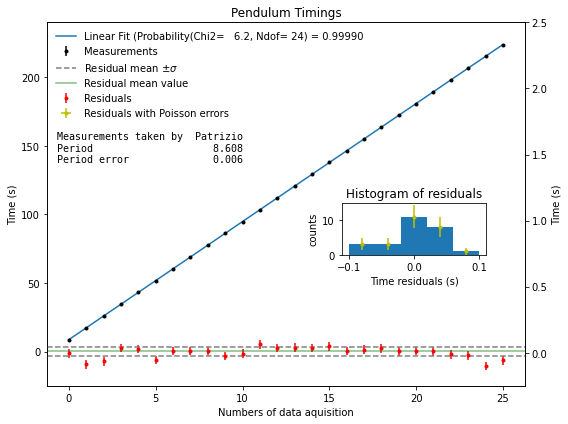

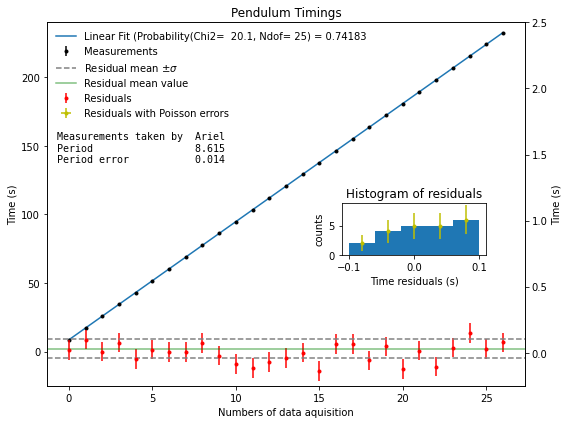

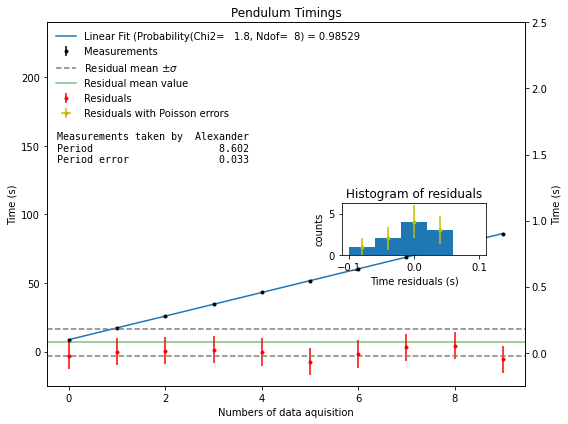

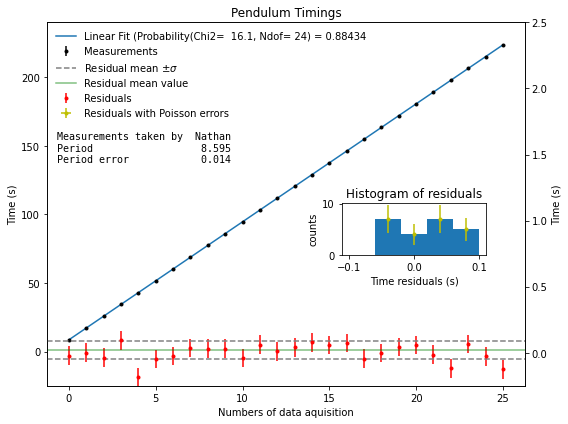

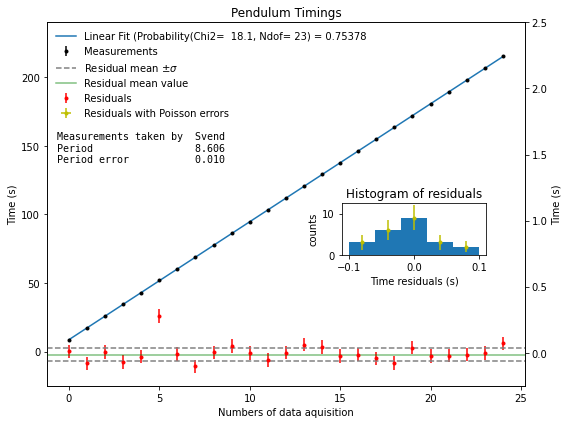

In [295]:
Sigma = []
Time_arr = []
for index in range(len(testurls)):

  t = Data_reader(testurls, index)

  fig, ax, alpha0, alpha1 = Fit_timing(t)

  sigma, meantime = fit_Residuals(t, fig, ax, alpha0, alpha1, Author[index])

  Sigma.append(sigma)
  Time_arr.append(meantime)

In [296]:

Measures=([8.65, 0.05, 1848   , 2   , 3.000, 0.005],[8.75, 0.05, 1849.60, 0.15, 3.005, 0.005],[8.5 , 0.1 , 1849.2 , 0.1 , 3.01 , 0.01],[8.65, 0.05, 1849.2 , 0.1 , 2.990, 0.005
])
Measures=np.array(Measures)
L_bottom=Measures[:,0]*0.01
dL_bottom=Measures[:,1]*0.01
L_top=Measures[:,2]*0.01
dL_top=Measures[:,3]*0.01
L_mass=Measures[:,4]*0.01
dL_mass=Measures[:,5]*0.01
N=4
pi=np.pi 

weight_L_bottom=1/(dL_bottom**2) #here we do the weights for the weighted means
weight_L_top=1/(dL_top**2)
weight_L_mass=1/(dL_mass**2)

dL_Top=(sum(dL_top**2)/N)**(1/2)
dL_Bottom=(sum(dL_bottom**2)/N)**(1/2)
dL_Mass=(sum(dL_mass**2)/N)**(1/2)

L_Top=sum(L_top)/N
L_Bottom=sum(L_bottom)/N
L_Mass=sum(L_mass)/N


L_Top_weight=(sum(L_top*weight_L_top)/sum(weight_L_top))  #here we do the weighted means 
L_Bottom_weight=(sum(L_bottom*weight_L_bottom)/sum(weight_L_bottom))
L_Mass_weight=(sum(L_mass*weight_L_mass)/sum(weight_L_mass))
dL_Top_weight=(sum(1/(weight_L_top)))**(1/2)
dL_Bottom_weight=(sum(1/(weight_L_bottom)))**(1/2)
dL_Mass_weight=(sum(1/(weight_L_mass)))**(1/2)


L_Tape=L_Top-L_Mass/2
L_Tape_weight=L_Top_weight-L_Mass_weight/2

dL_Tape_weight=((dL_Top_weight**2)+(dL_Mass_weight**2)*(1/4))**(1/2)

dL_Tape=((dL_Top**2)+(dL_Mass**2)*(1/4))**(1/2)

print('L tape and dL tape',L_Tape,dL_Tape)
print('L tape weighted and dL tape weighted',L_Tape_weight,dL_Tape_weight)


L_laser_top=np.array([18.766,18.762])
L_laser_bottom=0.32
dL_laser_bottom=0.001
dL_laser_top=np.array([0.001,0.0005])
weight_Laser=1/(dL_laser_top**2)
L_laser_top_weight=sum(L_laser_top*weight_Laser)/(sum(weight_Laser))
dL_laser_top_weight=(sum(1/(weight_Laser)))**(1/2)

L_Laser=L_laser_top_weight-L_laser_bottom-L_Mass/2
dL_Laser=((dL_laser_top_weight**2)+(dL_laser_bottom**2)+(dL_Mass**2)*(1/4))**(1/2)

print('L Laser and dL Laser',L_Laser,dL_Laser)


L_tot=(L_Laser*(1/dL_Laser**2)+L_Tape_weight*(1/dL_Tape_weight**2))/(1/dL_Laser**2+1/dL_Tape_weight**2)
dL_tot=(1/(1/dL_Laser**2+dL_Tape_weight**2))**(1/2)
#g2=(4*(pi**2)*(L_Tape))/(T**2)

print('Here we have L_tot and dL combined as above',L_tot,dL_tot)

dT=0.8 #here I put provvisory dT 


TotalT=([8.249,0.8],[8.620,0.8],[8.601,0.067],[8.614,0.102],[8.607,0.081]) #here we should put the error on the timings 
TotalT=np.array(TotalT)
times=TotalT[:,0]
dTimes=TotalT[:,1]

weight_T=1/(dTimes**2)

T_tot=sum(times*weight_T)/(sum(weight_T))
dT_tot=(1/(sum(weight_T)))**(1/2)

contribution_dT=(64*(pi**4)*(L_tot**2)*(dT**2))/(T_tot**6)
contribution_dL=(16*(pi**4)*(dL_tot**2))/(T_tot**4)
factor_dT=(64*(pi**4)*(L_tot**2))/(T_tot**6)
factor_dL=(16*(pi**4))/(T_tot**4)

print(contribution_dT,'If we squadre sigma_g this is the contribution by the error on dT')
print(contribution_dL,'If we squadre sigma_g this is the contribution by the error on dL')
print(factor_dT, 'factor that multiplies dT')
print(factor_dL, 'factor that multiplies dL')



dg=((64*(pi**4)*(L_tot**2)*(dT_tot**2))/(T_tot**6)+(16*(pi**4)*(dL_tot**2))/(T_tot**4))**(1/2)
#dL_Mass what??

print(dL_Mass)
g=(4*(pi**2)*(L_tot))/(T_tot**2)

print('l_tot' ,L_tot)
print('t_tot' ,T_tot)
print(g,dg)


L tape and dL tape 18.474993750000003 0.010053039030561853
L tape weighted and dL tape weighted 18.47771811565095 0.020106078061123706
L Laser and dL Laser 18.42779375 0.0015003645390370966
Here we have L_tot and dL combined as above 18.428070214736955 0.0015003645383544198
3.3386895321112102 If we squadre sigma_g this is the contribution by the error on dT
6.400555119514184e-07 If we squadre sigma_g this is the contribution by the error on dL
5.216702393923765 factor that multiplies dT
0.2843309002718694 factor that multiplies dL
6.614378277661476e-05
l_tot 18.428070214736955
t_tot 8.604464622704455
9.826342293741906 0.10486417568144561


In [297]:
Sigma = np.array(Sigma)
Time_arr = np.array(Time_arr)
#Time = Time_arr.sum()/len(Time_arr)
Time = np.average(Time_arr, weights=Sigma) #using weighted mean
dTime = Sigma.sum()/len(Sigma)

print(f'time:{Time:.5f}+/-{dTime:.5f}')

time:8.60402+/-0.01540


In [298]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
  
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [299]:
from sympy import *

g, L , T = symbols("g, L, T")
dg, dL, dT = symbols("sigma_g, sigma_L, sigma_T")

g = L * (2*pi / T)**2
dg = sqrt((g.diff(L) * dL)**2 + (g.diff(T) * dT)**2)
lprint(latex(Eq(symbols('g'),g)))
lprint(latex(Eq(symbols('sigma_g'), dg)))

fg = lambdify((L,T), g)
fdg = lambdify((L,dL,T, dT), dg)

vL, vdL = L_tot, dL_tot
vT, vdT = Time, dTime

vg = fg(vL, vT)
vdg = fdg(vL, vdL, vT, vdT)
lprint(fr'g = ({vg:.4f} \pm {vdg:.4f})\, \mathrm{{m/s^2}}')



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>